# CS526 Final Project Submission - NCDOT Contract Unit Prices Prediction
## Jon Calvin Wetzel
### May 2, 2025

#### Notebook Table of Contents
- Problem Statement
- Data Collection
- Data Preprocessing and Visualization
- Unit Price Prediction - KNN Regression with Kernel PCA
- Conclusion, Shortcomings,and Suggestions for Future Work

## Problem Statement

Across the United States, state departments of transportation (DOTs), such as NCDOT, manage highway infrastructure and transporation related construction projects. Such projects are drawn up and detailed by state engineers so that state contractors can adequately follow a construction plan. Before construction can begin, state DOTs release the project plans for statewide contractors to bid on, where the lowest bidder receives/wins the contract. Although a contractor would like to win the bid by offering the lowest price for job completion, the contractor does not want to bid signficantly lower than their competition as that represents money left on the table i.e., the dollar difference between the first and second place bidders. Futhermore, consistently bidding too low drives the market prices down and can result in reduced future profits.

Consequently, contractors continuously analyze the bidding history and behavior of their competition, as it relates to the current job they would like to bid on, with the goal to bid lower than their competition and simultaneously minimize money left on the table. Given the publically available information regarding these historic, current, and upcoming contracts, one can attempt to use machine learning to help contractors win more work at the right price while minimizing money left on the table. 

## Data Collection

Every DOT hosts a website that records and publishes contract information for statewide projects. Included in this information is an list of items (payitems) required and bid on for each project. Each contractor must charge a price for each item within the project. The contractor's proposed price is then multiplied by the payitem's quantity, which is then summed across all payitems to produce the contractor's final total bid amount for the contract.  

[NCDOT Website](https://connect.ncdot.gov/letting/Central%20Letting/Forms/BidTabs.aspx)

__Figure 1: NCDOT Page Containing Contract Information__

![NCDOTWebsite](imgs/NCDOTpage.png)

As depicted in the image, contract information dates back to 2013. Futhermore, each month's letting (collection of contracts for the month) containes an excel file with the pay items, quantities, and unit prices (data) for each project. 

__Figure 2: April 15, 2014 Letting Block with Link to Excel File Containing Data for Contracts__

![Excel Link](imgs/NCDOTexcellink.png)

Given the large number of contracts and pagination format of the NCDOT website, the data collection process would be tedious. It can be automated by using a [Selenium](https://www.selenium.dev/) script to download the excel files over a specified date range. 

The Selenium module permits interaction with a web browser via code, which can replicate user interaction with a website e.g., clicking links, navigating the pages, etc. This can signficantly enhance the data collection and data update workflow!

The code below utilizes Selenium to navigate the NCDOT website and download the excel files into a local directory.

In [7]:
import os
import time
from datetime import datetime

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait


def setup_driver():
    options = webdriver.ChromeOptions()

    download_dir = os.path.join(os.getcwd(), "ExcelFiles")
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    options.add_experimental_option(
        "prefs",
        {
            "download.default_directory": download_dir,
            "download.prompt_for_download": False,
            "download.directory_upgrade": True,
            "safebrowsing.enabled": True,
            "plugins.always_open_pdf_externally": True,  
            "download.open_pdf_in_system_reader": False,
            "profile.default_content_settings.popups": 0,
            "download.default_directory": download_dir,
            "safebrowsing.enabled": True,
            "profile.content_settings.exceptions.automatic_downloads.*.setting": 1,
            "profile.default_content_setting_values.automatic_downloads": 1,
            "download.prompt_for_download": False,
            "plugins.plugins_list": [
                {"enabled": False, "name": "Chrome PDF Viewer"}
            ],
            "download.extensions_to_open": "",
            "profile.default_content_settings.popups": 0,
            "download.default_directory": download_dir,
        },
    )

    options.add_argument("--disable-extensions")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-popup-blocking")

    return webdriver.Chrome(options=options)


def parse_date(date_str):
    try:
        return datetime.strptime(date_str, "%m/%d/%Y")
    except:
        return None


def download_excel_file(driver):
    try:
        excel_link = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "a.ms-listlink.ms-draggable[app='ms-excel']")
            )
        )

        download_url = excel_link.get_attribute("href")
        file_name = excel_link.text
        print(f"Downloading: {file_name}")

        js_script = f"""
        var link = document.createElement('a');
        link.href = '{download_url}';
        link.download = '{file_name}.xls';
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
        """
        driver.execute_script(js_script)

        time.sleep(3)  
        return True
    except Exception as e:
        print(f"Error downloading Excel file: {str(e)}")
        return False


def get_all_page_urls(driver, base_url):
    urls = [base_url]
    try:
        while True:
            next_button = driver.find_element(
                By.CSS_SELECTOR,
                "a.ms-commandLink.ms-promlink-button.ms-promlink-button-enabled img.ms-promlink-button-right",
            ).find_element(By.XPATH, "..")

            if next_button.is_displayed() and next_button.is_enabled():
                next_button.click()
                time.sleep(2)
                current_url = driver.current_url
                urls.append(current_url)
                print(f"Found page {len(urls)}: {current_url}")
            else:
                break

    except NoSuchElementException:
        print(f"Total pages found: {len(urls)}")

    return urls


def navigate_letting_pages():
    driver = setup_driver()
    cutoff_date = datetime(2022, 1, 1)
    main_window = None
    base_url = (
        "https://connect.ncdot.gov/letting/Central%20Letting/Forms/BidTabs.aspx"
    )

    try:
        print("Discovering all pages...")
        driver.get(base_url)
        time.sleep(3)
        page_urls = get_all_page_urls(driver, base_url)
        print(f"Found {len(page_urls)} pages")

        for page_num, url in enumerate(page_urls, 1):
            print(f"\nProcessing page {page_num} of {len(page_urls)}")
            driver.get(url)
            time.sleep(3)

            if main_window is None:
                main_window = driver.current_window_handle

            table_rows = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located(
                    (By.CSS_SELECTOR, "tr.ms-itmhover")
                )
            )

            for row in table_rows:
                try:
                    date_cell = row.find_element(
                        By.CSS_SELECTOR, "td[role='gridcell'] span.ms-noWrap"
                    )
                    date_text = date_cell.get_attribute("title")
                    letting_date = parse_date(date_text)

                    if letting_date and letting_date > cutoff_date:
                        link = row.find_element(
                            By.CSS_SELECTOR, "a.ms-listlink.ms-draggable"
                        )
                        print(f"Processing: {link.text} - Date: {date_text}")

                        href = link.get_attribute("href")
                        driver.execute_script(
                            "window.open(arguments[0]);", href
                        )

                        driver.switch_to.window(driver.window_handles[-1])

                        if download_excel_file(driver):
                            print("Successfully downloaded Excel file")

                        driver.close()
                        driver.switch_to.window(main_window)
                        time.sleep(2)
                    else:
                        print(f"Skipping: Date {date_text} is before cutoff")

                except Exception as e:
                    print(f"Error processing row: {str(e)}")
                    continue

    except Exception as e:
        print(f"An error occurred: {str(e)}")

    finally:
        driver.quit()

__Run the Selinium Script (Note this is not necessary since I have already run the script and saved the excel files to the `ExcelFiles` directory)__

In [ ]:
navigate_letting_pages()

## Data Preprocessing and Visualization

Once the excel files are downloaded to a local directory, they can be opened and saved as csv files using the `csv` module. In most scenarios, pandas can be used to complete this task. However, the complex nature of the excel sheet layouts requires a custom script for parsing the excel files and extracting the information necessary to create the individual contract csv files.  

__Figure 3: Example Excel Sheet with Raw Project Data. Note the Contract Total Cells at the Bottom. Each Excel Sheet Contains multiple projects like this. The raw excel sheets are located in the `ExcelFiles` directory.__

![ExcelSheet](imgs/ExcelSheet.png)

The code below reads the excel sheets, extracts the raw data for each contract, and writes the information to a csv file for each contract. Consquently, each contract is represented by its own csv file in the `nc_csv` directory.

In [ ]:
import csv
import shutil
from pathlib import Path
from typing import Dict, List

import pandas as pd


def read_excel(file_path: Path) -> pd.DataFrame:
    return pd.read_excel(file_path, header=None)


def desired_general_columns(
    general_contract_info: pd.DataFrame,
) -> pd.DataFrame:
    desired_columns = general_contract_info.iloc[
        :,
        [2, 5, 9, 12, 13, 14, 16, 18, 19, 20, 21, 22],
    ].copy()
    desired_columns.rename(
        columns={
            2: "Date",
            5: "Proposal",
            9: "County",
            12: "Proposal Type",
            13: "Proposal Description",
            14: "Item",
            16: "Line Item",
            18: "Item Type",
            19: "Item Description",
            20: "Item Description Subset",
            21: "Quantity",
            22: "Unit",
        },
        inplace=True,
    )
    desired_columns["Date"] = pd.to_datetime(desired_columns["Date"])
    desired_columns["Line Item"] = pd.to_numeric(
        desired_columns["Line Item"], errors="coerce"
    ).fillna(0)
    # Get mask of original empty values
    empty_mask = desired_columns["Line Item"] == 0
    # Forward fill values
    filled_values = desired_columns["Line Item"].ffill()
    # Where values were empty, add 1 to previous value
    desired_columns.loc[empty_mask, "Line Item"] = filled_values[empty_mask] + 1
    desired_columns["Line Item"] = desired_columns["Line Item"].astype(int)
    return desired_columns


def contractor_per_payitem(contract_df: pd.DataFrame) -> Dict:
    contract_df = contract_df.reset_index(drop=True)
    contractor_payitems = contract_df.iloc[:, 24:]
    contract_information = dict()
    proposal_id = None
    for row in range(0, contractor_payitems.shape[0]):
        for col in range(0, contractor_payitems.shape[1] - 1, 5):
            general_contract_row_info = desired_general_columns(
                contract_df.iloc[row, :24].to_frame().T
            )
            line_item = general_contract_row_info.at[row, "Line Item"]
            contractor = contractor_payitems.iloc[row, col]
            if pd.isna(contractor) or contractor == "" or contractor == " ":
                continue
            unit_price = contractor_payitems.iloc[row, col + 2]
            extension = contractor_payitems.iloc[row, col + 3]

            if line_item not in contract_information:
                contract_information[line_item] = dict()

            contract_information[line_item][contractor] = {
                "unit_price": unit_price,
                "extension": extension,
                "general_contract_row_info": general_contract_row_info.reset_index(
                    drop=True
                ),
            }
            if proposal_id is None:
                proposal_id = str(
                    general_contract_row_info.at[row, "Proposal"]
                ).strip()

    return contract_information, proposal_id


def format_and_write_to_csv(
    contract_information: Dict, proposal: str, path=Path.cwd() / "nc_csv"
) -> None:
    HEADER = [
        "Proposal",
        "Proposal Type",
        "Proposal Description",
        "Line",
        "Item",
        "Item Type",
        "Item Description",
        "Item Description Subset",
        "Quantity",
        "Unit",
        "Vendor Name",
        "Unit Price",
        "Extension",
        "County",
        "Date",
    ]
    Path.mkdir(path, exist_ok=True)

    with open(path / f"{proposal}.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(HEADER)
        for line_item, contractors in contract_information.items():
            for contractor, data in contractors.items():
                general_contract_row_info = data["general_contract_row_info"]
                row = [
                    general_contract_row_info.at[0, "Proposal"],
                    general_contract_row_info.at[0, "Proposal Type"],
                    general_contract_row_info.at[0, "Proposal Description"],
                    general_contract_row_info.at[0, "Line Item"],
                    general_contract_row_info.at[0, "Item"],
                    general_contract_row_info.at[0, "Item Type"],
                    general_contract_row_info.at[0, "Item Description"],
                    general_contract_row_info.at[0, "Item Description Subset"],
                    general_contract_row_info.at[0, "Quantity"],
                    general_contract_row_info.at[0, "Unit"],
                    contractor,
                    data["unit_price"],
                    data["extension"],
                    general_contract_row_info.at[0, "County"],
                    general_contract_row_info.at[0, "Date"].strftime(
                        "%m/%d/%Y"
                    ),
                ]
                writer.writerow(row)


def process_letting_group_excel(raw_df: pd.DataFrame) -> None:
    valid_rows = raw_df[16].notna()
    unique_contracts = raw_df[4].unique().tolist()
    for i in unique_contracts:
        contract_df = raw_df[valid_rows & (raw_df[4] == i)]
        assert contract_df.shape[0] > 0, "Contract dataframe is empty"
        contract_info, proposal = contractor_per_payitem(contract_df)
        format_and_write_to_csv(contract_info, proposal)

In [ ]:
excel_lettings_directory_path = Path.cwd() / "ExcelFiles"
shutil.rmtree(Path.cwd() / "nc_csv", ignore_errors=True)
for file_path in excel_lettings_directory_path.glob("*.xls"):
    raw_excel_df = read_excel(file_path)
    process_letting_group_excel(raw_excel_df)

The resulting csv file for each contract looks like this:

__Figure 4: CSV file for an individual contract. The parsed csv files for each contract are located in the `nc_csv` directory.__

![ContractCSVFile](imgs/CSVFile.png)

With a consistent csv format and data across all contracts, data analysis can take place. Through discussion with aformer estimator, Tristan Wilson, who is the CEO of [Edgevanta](https://www.edgevanta.io/) (Highway Contracting SAAS company) and a domain expert, I reached several conclusions. First, Tristan mentioned how contracts for similar jobs will feature similar pay items and pricing structures. In other words, contracts tend to _cluster_ based on the job type. To explore this phenomena, I used an embedding model to create 1024-dimensional vectors based on the text of each contract. Below are the visualization results using the DBSCAN clustering algorithm. __Note that TSNE was required to reduce the dimensionality to 2D for visualization purposes. Therefore, the visualizations are not representative of the true dimensionality of the data. The code used to produce these plots is available in `src/explore_jina_embeddings.py`__.

__Figure 5: DBSCAN Clustering of Contracts (based on embeddings of textual information in each contract)__

![DBSCANClustering](plots/tsne_clusters.png)
![SilhouetteScore](plots/silhouette_heatmap.png)

For further exploration, I plotted the relationships between several variables in my dataset. Below, I select 3 random payitems and plot the relationships amongst the dataframe variables. 

In [30]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import random

def combine_csv_files_to_single_df(dir: Path) -> pd.DataFrame:
    files = dir.glob("*.csv")
    df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    return df

cwd = Path.cwd()
all_contracts_df = combine_csv_files_to_single_df(cwd / "nc_csv")
list(all_contracts_df.columns)


['Proposal',
 'Proposal Type',
 'Proposal Description',
 'Line',
 'Item',
 'Item Type',
 'Item Description',
 'Item Description Subset',
 'Quantity',
 'Unit',
 'Vendor Name',
 'Unit Price',
 'Extension',
 'County',
 'Date',
 'Total Contract Amount',
 'Latitude',
 'Longitude']

__Figure 6: Pairplot of variable relationships for a random payitems contained in the dataset__

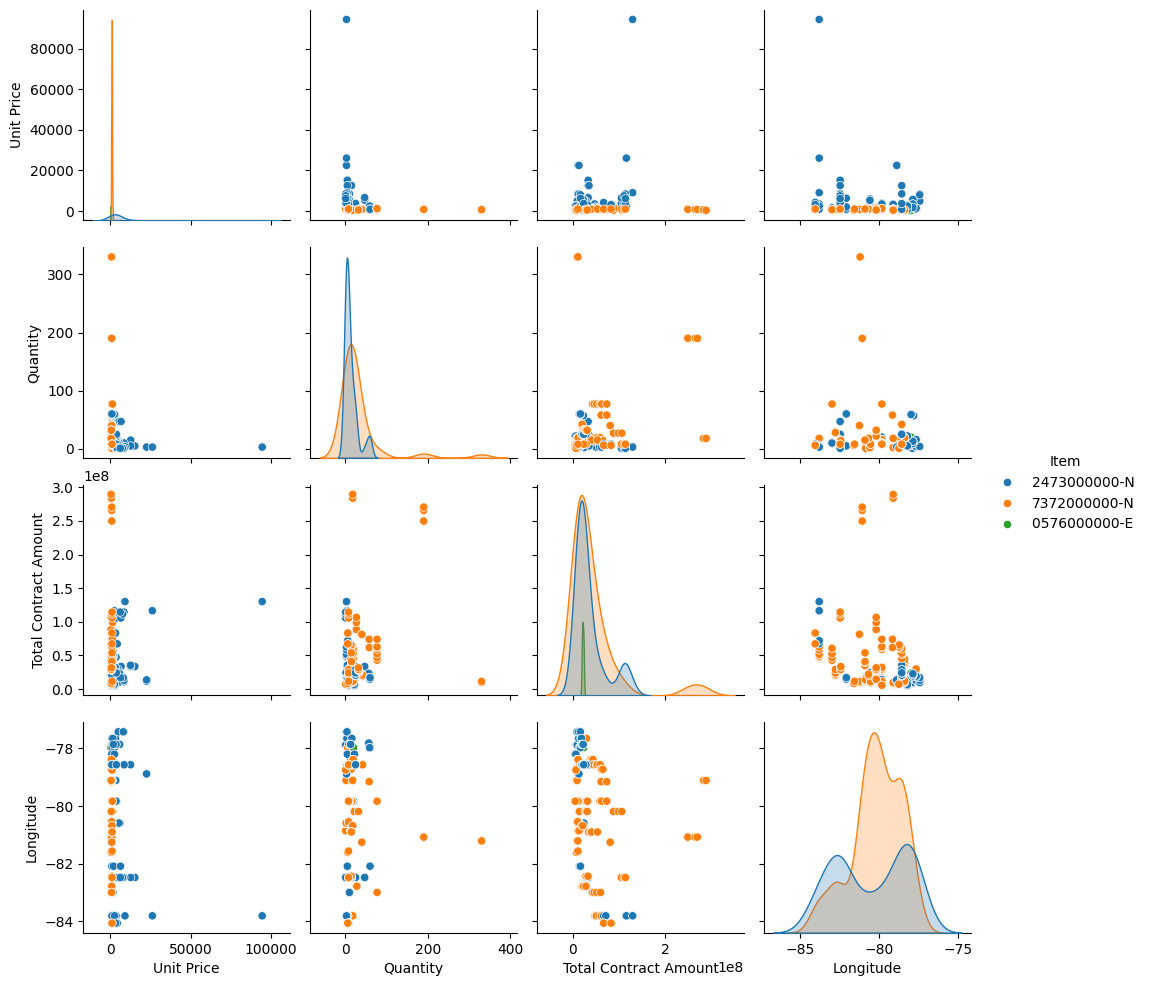

In [21]:
random_item = random.sample(all_contracts_df["Item"].unique().tolist(), 3)
random_item_df = all_contracts_df[all_contracts_df["Item"].isin(random_item)]
pairplot_colums = ["Unit Price", "Quantity", "Total Contract Amount", "Longitude", "Item"]
sns.pairplot(random_item_df[pairplot_colums], hue="Item");


Futhermore, Tristan detailed how estimators consider particular variables over others. As a result, I setteled on four primary variables that effect payitem unit prices (must balance context vs dimensionality in KNN Models else you'll run into the curse of dimensionality): 
- __Location__: contracts in similar locations within a state tend to align/bid similarly
- __Contract Outline__: types of payitems featured in the contract, the type of work to be completed, and the group of contractors that intend to/have bid on the job.
- __Quantity__: the quantity associated with the payitem. Contractors tend to change their pricing structure based on the volume required for the contract
- __Contract Size in Dollars__: really large contracts have different pricing structures than smaller contracts e.g., $50 million contract vs $5 million contract

Like most ML problems, not only do the variables that you select matter, but also the means by which you decide to represent them. As a result, I used the following representation for the aforementioned variables:

- __Location as Distance__: each contract has an associated county such as Pitt in Fig. 4. Therefore, one can query Google Maps via an api to capture latitude and longitude information. From there, you can calculate the distance from one contract's location to any other contract's location, which benefits the latter KNN Regression model i.e., longitude/latitude turns into distance (trading two variables for one). The code below performs this task. Note that the returned coordinates can be confirmed by plotting them on a map. __Also, I have removed my API key since Google Maps charges for API calls__:

In [ ]:
import csv
import os
import random
import time
from pathlib import Path
from statistics import mean

import folium
import pandas as pd
import requests
from dotenv import load_dotenv
from folium.plugins import MarkerCluster
from tqdm import tqdm


def query_google_maps(county):
    load_dotenv()
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    max_retries = 5
    initial_delay, max_delay = 1, 60
    for attempt in range(max_retries):
        try:
            response = requests.get(
                base_url,
                params={
                    "address": f"{county} County, North Carolina, USA",
                    "key": os.getenv("GOOGLE_MAPS_API_KEY"), # removed my API key since Google Maps charges for API calls
                },
                timeout=5,
            )
            response.raise_for_status()
            data = response.json()

            if data["status"] == "OK":
                location = data["results"][0]["geometry"]["location"]
                return (location["lat"], location["lng"])
            elif data["status"] == "ZERO_RESULTS":
                print(f"No results found for {county} County")
                return None
            else:
                print(f"Error for {county} County: {data['status']}")

        except requests.exceptions.Timeout:
            print(f"Timeout error for {county} County")
        except requests.exceptions.RequestException as e:
            print(f"Request error for {county} County: {e}")
        except Exception as e:
            print(f"Unexpected error for {county} County: {e}")
        # Exponential backoff with jitter
        delay = min(
            initial_delay * (2**attempt) + random.uniform(0, 1), max_delay
        )
        print(f"Retrying {county} County in {delay:.2f} seconds...")
        time.sleep(delay)
    return None


def get_county_coordinates(counties: list):
    county_coords = {}
    for county in tqdm(counties, desc="Querying Google Maps"):
        coords = query_google_maps(county)
        if coords:
            county_coords[county] = coords
        time.sleep(0.1)  # Delay between requests
    return county_coords


def create_map(county_coordinates: dict) -> None:
    m = folium.Map(location=county_coordinates["All Counties"], zoom_start=6)
    marker_cluster = MarkerCluster().add_to(m)
    for county, coords in county_coordinates.items():
        folium.Marker(
            location=coords,
            popup=f"{county} County",
            tooltip=f"{county} County",
        ).add_to(marker_cluster)
    title_html = """
        <h3 align="center" style="font-size:20px"><b>North Carolina Counties</b></h3>
        """
    m.get_root().html.add_child(folium.Element(title_html))
    m.save("county_coords/nc_counties_map.html")
    print(
        "Map created successfully and saved as county_coords/nc_counties_map.html"
    )
    return None

In [ ]:
cwd = Path.cwd()
contracts_df = combine_csv_files_to_single_df(cwd / "nc_csv")

# Process each county and get coordinates
counties = contracts_df["County"].unique().tolist()
counties = [county.lower().title().split(",") for county in counties]
counties = [county[0].strip() for county in counties]
print(f"Counties: {counties}")

# Load or create county coordinates
if not Path("county_coords/nc_county_coords.csv").exists():
    county_coords = get_county_coordinates(counties)
    county_coords["All Counties"] = (
        mean([coord[0] for coord in county_coords.values()]),
        mean([coord[1] for coord in county_coords.values()]),
    )
else:
    county_coords = {}
    with open("county_coords/nc_county_coords.csv", "r") as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            county_coords[row[0]] = (float(row[1]), float(row[2]))

# Save county coordinates
Path("county_coords").mkdir(exist_ok=True)
with open("county_coords/nc_county_coords.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["County", "Latitude", "Longitude"])
    for county, coords in county_coords.items():
        writer.writerow([county, *coords])

csv_files = list(cwd.glob("nc_csv/*.csv"))
for csv_file in csv_files:
    single_contract_df = pd.read_csv(csv_file)
    # Initialize new columns
    single_contract_df["Latitude"] = None
    single_contract_df["Longitude"] = None
    for idx, row in single_contract_df.iterrows():
        county_list = row["County"].lower().title().split(",")
        county_list = [c.strip() for c in county_list]

        if len(county_list) == 1:
            # Single county
            county = county_list[0]
            if county in county_coords:
                lat, lon = county_coords[county]
                single_contract_df.at[idx, "Latitude"] = lat
                single_contract_df.at[idx, "Longitude"] = lon
        else:
            # Multiple counties - take average
            lats = []
            lons = []
            for county in county_list:
                if county in county_coords:
                    lat, lon = county_coords[county]
                    lats.append(lat)
                    lons.append(lon)
            if (
                lats and lons
            ):  # If we found coordinates for at least one county
                single_contract_df.at[idx, "Latitude"] = mean(lats)
                single_contract_df.at[idx, "Longitude"] = mean(lons)
    single_contract_df.to_csv(csv_file, index=False)

create_map(county_coords)

__Figure 6: North Carolina County Locations__
- Open run the command below to view the iteractive map of the North Carolina Counties

In [3]:
!open county_coords/nc_counties_map.html

![North Carolina Counties](imgs/NCcounties.png)

- __Contract Outline__ - although a multi-hot encoded vector could represent the pay items that are present in a contract, the high dimensionality and sparsity resulting from thousands of payitems prove difficult for a KNN based algorithm. Futhermore, a multi-hot encoded vector does not account for the descriptions of the payitems, contract, or the remaining textual information present in the contract, which would provide further context for any algorithm. To tackle this challenge, I relied a 1024-dimensional texual embedding to represent a contract and used cosine similarity to relate various contracts i.e., [0,1] scale, which is then a compatible form of 'distance' for a KNN model dimension. To create the embedding, I used an API call to [JINA](https://jina.ai/embeddings/), which is a state-of-the-art (SOTA) embedding model for textual and visual information. (You can read their paper [here](https://arxiv.org/abs/2409.10173)). The API call then returns the embedding vectors for each contract as a json file, which I can then parse and compare contracts via cosine similarity between two vectors. __Note that I have removed my API key from the code. The embeddings are saved in the repository as json files (`embeddings/jina_embedding_proposalIndex_response.json`)__. See the code below:

In [ ]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

def generate_text_string(contract_df: pd.DataFrame) -> str:
    text_columns = [
        "Item Description",
        "Item Description Subset",
        "Quantity",
        "Unit",
    ]
    proposal_type = contract_df.at[0, "Proposal Type"]
    proposal_description = contract_df.at[0, "Proposal Description"]
    item_types = contract_df["Item Type"].unique().tolist()
    item_types = ", ".join(item_types)
    unique_item_info = contract_df[text_columns].astype(str).drop_duplicates()
    unique_item_info.replace(
        {"Item Description Subset": {"nan": ""}}, inplace=True
    )
    item_description_list = unique_item_info["Item Description"].tolist()
    item_description_subset_list = unique_item_info[
        "Item Description Subset"
    ].tolist()
    quantity_list = unique_item_info["Quantity"].tolist()
    unit_list = unique_item_info["Unit"].tolist()
    vendor_name_list = contract_df["Vendor Name"].unique().tolist()

    total_string = " ".join(
        [
            proposal_type,
            proposal_description,
            item_types,
        ]
    )
    total_string += "\n" + ", ".join(vendor_name_list) + "\n"
    for (
        item_description,
        item_description_subset,
        quantity,
        unit,
    ) in zip(
        item_description_list,
        item_description_subset_list,
        quantity_list,
        unit_list,
    ):
        total_string += " ".join(
            [
                item_description.strip(),
                item_description_subset.strip(),
                quantity.strip(),
                unit.strip(),
            ]
        )
        total_string += "\n"
    total_string += ", ".join(vendor_name_list) + "\n"
    total_string = total_string.replace("\n", "")
    return total_string


def rename_json_index(response: dict, csv_files: list):
    for i, csv_embedding in enumerate(response["data"]):
        csv_embedding["index"] = f"{csv_files[i]}"
    return response


def main():
    data_path = Path("nc_csv")
    texts = []
    csv_files = [csv_file.stem for csv_file in sorted(data_path.glob("*.csv"))]
    tokens = 0

    for csv_file in sorted(data_path.glob("*.csv")):
        contract_df = pd.read_csv(csv_file)
        text = generate_text_string(contract_df)
        texts.append(text)
        tokens += len(text.split())

    url = "https://api.jina.ai/v1/embeddings"
    headers = {
        "Content-Type": "application/json",
        "Authorization": "YOUR API KEY HERE", # removed my API key since Jina charges for API calls
    }
    data = {
        "model": "jina-embeddings-v3",
        "task": "text-matching",
        "late_chunking": False,
        "dimensions": 1024,
        "embedding_type": "float",
        "input": [{"text": text} for text in texts],
    }
    try:
        response = requests.post(url, json=data, headers=headers)
        response.raise_for_status() 
    except requests.exceptions.HTTPError as e:
        response = e.response
        print(f"Status code: {response.status_code}")
        print(f"Reason: {response.reason}")
        print(f"Response Headers: {response.headers}")
        print(f"Response Content: {response.text}")
    with open("original_jina_embedding_api_response.json", "w") as f:
        json.dump(response.json(), f, indent=2)
    json_response = response.json()
    modified_response = rename_json_index(json_response, csv_files)

    with open("jina_embedding_proposalIndex_response.json", "w") as f:
        json.dump(modified_response, f, indent=2)

In [ ]:
main()

__Figure 7: JSON File format containing the embeddings for the textual information in each contract's csv file__

![JSON_Embedding_Response](./imgs/Embedding.png)

- __Quantity__ - the quantity associated with each payitem for a given contract was already present in the csv files and could be taken as they were

- __Contract Size in Dollars__ - multiplied the payitem unit prices by their associated quantities and then summed to get total contract size. Each payitem within that contract is then associated with that contract size. This works great for past contracts that have already been bid on i.e., unit prices released after contract is rewarded. However, for an inference contract that is yet to be bid on, unit prices are not present and can't be used to determine contract size in dollars. However, total contract size can be estimated by taking a global average, across all contracts, of each payitem's unit price, weighted by quantity, and multiplying that by the respective quantity present in the inference contract. Although not perfect, it serves as a good esitimation for the expected contract size in dollars. `global_weighted_avg_C204988.csv` contains an example estimation of contract size in dollars for an upcoming contract C204988. The code below accomplishes this:

In [ ]:
import shutil
from pathlib import Path

import numpy as np
import pandas as pd


def combine_csv_files_to_single_df(dir: Path) -> pd.DataFrame:
    files = dir.glob("*.csv")
    df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    return df


def add_extension_total_column(csv_path: Path) -> pd.DataFrame:
    rankings_path = Path("contract_rankings")
    rankings_path.mkdir(exist_ok=True)
    contract_df = pd.read_csv(csv_path)
    contract_id = str(contract_df.at[0, "Proposal"]).strip()
    contractor_groups = contract_df.groupby("Vendor Name")
    contract_rankings = dict()
    for contractor_name, group in contractor_groups:
        contract_df.loc[group.index, "Total Contract Amount"] = int(
            group["Extension"].sum()
        )
        contract_rankings[contractor_name] = int(group["Extension"].sum())

    contract_df.to_csv(csv_path, index=False)

    # Save dict to csv
    rankings_df = pd.DataFrame(
        contract_rankings.items(),
        columns=["Vendor Name", "Total Contract Amount"],
    )
    rankings_df = rankings_df.sort_values(
        "Total Contract Amount", ascending=True
    )
    rankings_df.to_csv(
        rankings_path / f"{contract_id}_rankings.csv", index=False
    )

    return contract_df, rankings_df


def compute_payitem_weighted_averages(combined_df: pd.DataFrame) -> None:
    weighted_path = Path("payitem_weightedaverages")
    weighted_path.mkdir(exist_ok=True)
    combined_df["Item"] = combined_df["Item"].str.strip()
    payitem_groups = combined_df.groupby("Item")
    weighted_averages = dict()
    for payitem, group in payitem_groups:
        if len(group.index) == 1:
            weighted_averages[payitem] = group["Unit Price"].values[0]
        else:
            weighted_averages[payitem] = np.round(
                np.average(group["Unit Price"], weights=group["Quantity"]), 2
            )
    weighted_averages_df = pd.DataFrame(
        weighted_averages.items(),
        columns=["Item", "Unit Price Weighted Average"],
    )
    weighted_averages_df = weighted_averages_df.sort_values(
        "Item", ascending=True
    )
    weighted_averages_df.to_csv(
        weighted_path / "weighted_averages.csv", index=False
    )


def estimate_contract_extension(inference_df: pd.DataFrame) -> int:
    weighted_averages = pd.read_csv(
        "payitem_weightedaverages/weighted_averages.csv"
    )
    estimated_extension = 0
    for item, quantity in zip(
        inference_df["Item"].tolist(), inference_df["Quantity"].tolist()
    ):
        if item not in weighted_averages["Item"].values or pd.isna(
            weighted_averages[weighted_averages["Item"] == item][
                "Unit Price Weighted Average"
            ].values[0]
        ):
            print(f"Item {item} not found in weighted averages")
            continue
        weighted_average = weighted_averages[weighted_averages["Item"] == item][
            "Unit Price Weighted Average"
        ].values[0]
        estimated_extension += float(weighted_average) * float(quantity)
    return round(estimated_extension, 2)

In [ ]:
dir = Path("nc_csv")
shutil.rmtree("contract_rankings", ignore_errors=True)
for file in dir.glob("*.csv"):
    contract_df, rankings_df = add_extension_total_column(file)
combined_df = combine_csv_files_to_single_df(dir)
compute_payitem_weighted_averages(combined_df)
inference_df = pd.read_csv(
    "~/Downloads/Proposal_NCDOT_L241217_C204988_003.csv"
)
estimated_extension = estimate_contract_extension(inference_df)
print(f"Estimated extension: {estimated_extension}")

With the four variables/dimensions transformed into their respective representations, a KNN Regression model could be built to predict a contract's unit prices for payitems based on the contract's values for the four aforementioned input variables. 

## Unit Price Prediction - KNN Regression with Kernel PCA

Helper functions for the main model loop

In [ ]:
import csv
import json
from dataclasses import dataclass
from functools import cache, lru_cache
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from geopy.distance import geodesic as GD

def estimate_inference_contract_size(
    total_df: pd.DataFrame,
    inference_contract_data: Tuple[List[str], List[float]],
    contract: str,
) -> float:
    total_size = 0
    payitems, quantities = inference_contract_data
    with open(f"global_weighted_avg_{contract}.csv", "w") as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(
            [
                "Payitem",
                "Global Weighted Avg",
                "Proposal Quantity",
                "Global Unit Price Prediction",
            ]
        )
        for payitem, quantity in zip(payitems, quantities):
            payitem_df = total_df[total_df["Item"] == payitem]
            quantities = np.array(payitem_df["Quantity"])
            unit_prices = np.array(payitem_df["Unit Price"])
            if len(quantities) == 0 or np.all(quantities == 0):
                continue
            payitem_global_weighted_avg = np.round(
                np.average(unit_prices, weights=quantities), 2
            )

            """
            print(
                f"Payitem: {payitem} - Weighted Avg: {payitem_global_weighted_avg}"
            )
            """

            total_size += payitem_global_weighted_avg * quantity
            global_unit_price_prediction = round(
                payitem_global_weighted_avg * quantity, 2
            )
            csv_writer.writerow(
                [
                    payitem,
                    payitem_global_weighted_avg,
                    quantity,
                    global_unit_price_prediction,
                ]
            )
        csv_writer.writerow(["", "", "Total", round(total_size, 0)])
    return total_size

@cache
def create_embedding_dict():
    embedding_dict = {}
    embedding_path = (
        Path().cwd()
        / "embeddings"
        / "jina_embedding_proposalIndex_response.json"
    )
    with open(embedding_path, "r") as f:
        embeddings = json.load(f)
    data: List = embeddings["data"]
    for info_dict in data:
        embedding_dict[info_dict["index"]] = np.array(
            info_dict["embedding"]
        ).tolist()
    return embedding_dict


@cache
def load_embedding(contract_id: str):
    embeddings = create_embedding_dict()
    return embeddings.get(contract_id, None)


contract_locations: Dict[str, Tuple[float, float]] = {}


def get_contract_location(contract: str) -> Tuple[float, float]:
    """Cache and return contract locations"""
    if contract not in contract_locations:
        df = pd.read_csv(f"nc_csv/{contract}.csv")
        contract_locations[contract] = (
            df.at[0, "Latitude"],
            df.at[0, "Longitude"],
        )
    return contract_locations[contract]


@lru_cache(maxsize=10000)
def load_distance(contract_one: str, contract_two: str) -> float:
    """
    Compute distance between contracts with multiple levels of caching:
    1. Contract locations are cached to avoid repeated CSV reads
    2. Distance computations are cached with lru_cache
    3. Symmetric computation (A->B same as B->A)
    """
    if contract_one > contract_two:
        contract_one, contract_two = contract_two, contract_one

    location_one = get_contract_location(contract_one)
    location_two = get_contract_location(contract_two)

    return float(GD(location_one, location_two).miles)


__KNN Regression Notes__
-  Each of the four variables are scaled to improve KNN Regression performance (degrades with unequal dimension scales)
-  Kernel PCA, with a Radial Basis Function, was used to transform the data into a new feature space that better captures nonlinear relationships between variables, before using these transformed features for prediction. The dimensionality of this newer space may be greater than the original 4 dimensions considered but will more accurately capture the non-linear relationships of the data and distances between points.
-  These predictions are made for each contractor's payitems in the contract, placed in a python dictionary, and then saved to an excel sheet within the `InferenceResults` directory
-  The dataset size for a contractor's particular payitem, over the 2.5yr window considered, ranged from ~1-250 historical examples per payitem. Such small dataset sizes are difficult to train DL algorithms. Consequently, a transductive model approach is more adequate because it makes its predictions directly from the training data without trying to learn a general function that maps inputs to outputs such as Neural Networks. 
- __Note that the model predicts the unit price for each payitem and also returns the nearest neighbors that contributed to the prediction. For estimators, this proves invaluable because even if the prediction appears slightly off, contractors can reference the most similar contracts to refine the prediction (don't have to search for contracts that you think may be similar; model does it for you!)__


The pandas output below illstrates an example proposal before making predictions. Note that no pricing information is present. The model ingests the pay items and historical data for each contractor then makes price predictions for each payitem for each contractor.

In [28]:
# Inference Proposal before making predictions
proposal_before_inference = pd.read_csv(f"InferenceProposals/C204988.csv")
proposal_before_inference.head(20)

,Line,Item,Quantity,Unit,Description,Price,Proposal,Call Order,Agency ID,Section,Is Favorite
0,1,0000100000-N,1.0,LS,MOBILIZATION,NaN,C204988,3,NCDOT,1,False
1,2,0000400000-N,1.0,LS,CONSTRUCTION SURVEYING,NaN,C204988,3,NCDOT,1,False
2,3,0015000000-N,3.0,EA,SEALING ABANDONED WELLS,NaN,C204988,3,NCDOT,1,False
3,4,0043000000-N,1.0,LS,GRADING,NaN,C204988,3,NCDOT,1,False
4,5,0050000000-E,1.0,ACR,SUPPLEMENTARY CLEARING & GRUBBING,NaN,C204988,3,NCDOT,1,False
5,6,0057000000-E,100.0,CY,UNDERCUT EXCAVATION,NaN,C204988,3,NCDOT,1,False
6,7,0134000000-E,7140.0,CY,DRAINAGE DITCH EXCAVATION,NaN,C204988,3,NCDOT,1,False
7,8,0195000000-E,100.0,CY,SELECT GRANULAR MATERIAL,NaN,C204988,3,NCDOT,1,False
8,9,0196000000-E,1000.0,SY,GEOTEXTILE FOR SOIL STABILIZATION,NaN,C204988,3,NCDOT,1,False
9,10,0199000000-E,500.0,SF,TEMPORARY SHORING,NaN,C204988,3,NCDOT,1,False


In [ ]:
import json
import os
import pickle
from dataclasses import dataclass
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import requests
from geopy.distance import geodesic as GD
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from calcs import predict_with_confidence
from contract_locations import query_google_maps
from inferenceExcel import excel_predictions
from model_helpers import (
    combine_csv_files,
    create_embedding_dict,
    estimate_inference_contract_size,
    load_distance,
)
from models import ImprovedKNNRegression


@dataclass
class InferenceProposal:
    proposal: str
    contractors: list[str]
    embedding: np.ndarray
    location: tuple
    estimated_contract_size: float = 0.0


class Inference:
    def __init__(
        self,
        embedding_dict: dict,
        combined_df: pd.DataFrame,
        inference_proposal: InferenceProposal,
    ):
        self.embedding_dict = embedding_dict
        self.combined_df = combined_df
        self.inference_proposal = inference_proposal
        self.inference()

    def inference(self):
        os.makedirs("InferenceResults", exist_ok=True)
        output: dict = {}
        output.setdefault(self.inference_proposal.proposal, {})
        contractor_list = self.inference_proposal.contractors
        payitems_df = pd.read_csv(
            f"InferenceProposals/{self.inference_proposal.proposal}.csv"
        )
        payitems_df["Item"] = payitems_df["Item"].str.strip()
        print(payitems_df)
        est_inference_contract_size = estimate_inference_contract_size(
            self.combined_df,
            (
                payitems_df["Item"].tolist(),
                payitems_df["Quantity"].astype(float).tolist(),
            ),
            self.inference_proposal.proposal,
        )
        self.inference_proposal.estimated_contract_size = (
            est_inference_contract_size
        )
        print(contractor_list)
        for contractor in contractor_list:
            output[self.inference_proposal.proposal].setdefault(contractor, {})
            for payitem in payitems_df["Item"]:
                print(f"Starting inference for {payitem} in {contractor}")
                inference_payitem_data = payitems_df[
                    payitems_df["Item"] == payitem
                ]
                line_item = inference_payitem_data["Line"]
                payitem_desc = inference_payitem_data["Description"]
                inference_quantity = inference_payitem_data["Quantity"]
                inference_unit = inference_payitem_data["Unit"].iloc[0]
                historic_data = self.combined_df[
                    (
                        self.combined_df["Proposal"].astype(str)
                        != self.inference_proposal.proposal
                    )
                    & (self.combined_df["Vendor Name"] == contractor)
                    & (self.combined_df["Item"] == payitem)
                ]
                if historic_data.empty:
                    print(f"No data found for {payitem} in {contractor}")
                    for line, quantity, desc in zip(
                        line_item, inference_quantity, payitem_desc
                    ):
                        output[self.inference_proposal.proposal][contractor][
                            f"{payitem}:{line}:{desc}"
                        ] = [
                            "N/A",
                            quantity,
                            "N/A",
                            0,
                            "N/A",
                            [],
                            inference_unit,
                        ]
                    continue

                historic_data = historic_data.copy()

                historic_data["Similarity"] = historic_data["Proposal"].apply(
                    lambda x: np.dot(
                        self.inference_proposal.embedding,
                        self.embedding_dict[x],
                    )
                    / (
                        np.linalg.norm(self.inference_proposal.embedding)
                        * np.linalg.norm(self.embedding_dict[x])
                    )
                )
                # compute distances
                historic_data["Distance"] = historic_data.apply(
                    lambda row: float(
                        GD(
                            self.inference_proposal.location,
                            (row["Latitude"], row["Longitude"]),
                        ).miles
                    ),
                    axis=1,
                )
                number_payitem_occurances = len(historic_data)
                # Scaling
                quantity_scaler = Pipeline(
                    [
                        ("robust", RobustScaler()),
                        ("minmax", MinMaxScaler()),
                    ]
                )
                distance_scaler = Pipeline(
                    [
                        ("robust", RobustScaler()),
                        ("minmax", MinMaxScaler()),
                    ]
                )
                contract_dollar_size_scaler = Pipeline(
                    [
                        ("robust", RobustScaler()),
                        ("minmax", MinMaxScaler()),
                    ]
                )
                features = [
                    "Quantity Scaled",
                    "Distance Scaled",
                    "Similarity",
                    "Total Contract Amount Scaled",
                ]

                historic_data["Quantity Scaled"] = (
                    quantity_scaler.fit_transform(historic_data[["Quantity"]])
                )
                historic_data["Distance Scaled"] = (
                    distance_scaler.fit_transform(historic_data[["Distance"]])
                )
                historic_data["Total Contract Amount Scaled"] = (
                    contract_dollar_size_scaler.fit_transform(
                        historic_data[["Total Contract Amount"]]
                    )
                )

                inference_quantity = pd.DataFrame(
                    inference_payitem_data["Quantity"], columns=["Quantity"]
                )

                contract_amount = pd.DataFrame(
                    [self.inference_proposal.estimated_contract_size],
                    columns=["Total Contract Amount"],
                )

                quantity_scaled = quantity_scaler.transform(inference_quantity)
                contract_amount_scaled = contract_dollar_size_scaler.transform(
                    contract_amount
                )

                inference_df = pd.DataFrame(
                    {
                        "Quantity Scaled": quantity_scaled.ravel(),
                    }
                )
                inference_df["Distance Scaled"] = 0
                inference_df["Similarity"] = 1
                inference_df["Total Contract Amount Scaled"] = (
                    contract_amount_scaled.item()
                )
                print(f"{'Inference data':-^50}")
                print(inference_df)
                print("\n")

                inference_df = inference_df[features]

                kpca = KernelPCA(
                    n_components=None, kernel="rbf", random_state=42
                )
                historic_kpca = kpca.fit_transform(historic_data[features])
                inference_kpca = kpca.transform(inference_df[features])

                eigenvalues = kpca.eigenvalues_
                total_variance = np.sum(eigenvalues)

                if total_variance > 0:
                    variance_ratio = eigenvalues / total_variance
                    cumulative_variance_ratio = np.cumsum(variance_ratio)
                    if np.any(cumulative_variance_ratio > 0.95):
                        n_components = (
                            np.argmax(cumulative_variance_ratio > 0.95) + 1
                        )
                    else:
                        n_components = len(cumulative_variance_ratio)
                    historic_kpca = historic_kpca[:, :n_components]
                    inference_kpca = inference_kpca[:, :n_components]
                    historic_kpca_df = pd.DataFrame(
                        historic_kpca,
                        columns=[f"PC{i+1}" for i in range(n_components)],
                    )
                    inference_kpca_df = pd.DataFrame(
                        inference_kpca,
                        columns=[f"PC{i+1}" for i in range(n_components)],
                    )

                    model_used = "KNN with Kernel PCA"
                    knn = ImprovedKNNRegression(
                        historic_kpca_df, historic_data["Unit Price"]
                    )
                    predictions, confidences, details = predict_with_confidence(
                        knn,
                        inference_kpca_df,
                        historic_kpca_df,
                        k=knn.best_k,
                    )
                    distances, indices = knn.model.kneighbors(
                        inference_kpca_df,
                        n_neighbors=knn.best_k,
                        return_distance=True,
                    )

                    for prediction, confidence in zip(predictions, confidences):
                        print(f"{model_used:-^50}")
                        print(f"Pay item: {payitem:10s}")
                        print(f"Description: {payitem_desc}")
                        print(f"Prediction: {prediction:10.2f}")
                        print(f"Confidence: {confidence:10.2f}")
                        print(f"Shape of input data: {historic_kpca.shape}")
                else:
                    print(
                        "Warning: All eigenvalues are zero or very close to zero. Using original features."
                    )
                    model_used = "KNN with original features"
                    knn = ImprovedKNNRegression(
                        historic_data[features],
                        historic_data["Unit Price"],
                    )
                    predictions, confidences, details = predict_with_confidence(
                        knn,
                        inference_df,
                        historic_data[features],
                        k=knn.best_k,
                    )
                    distances, indices = knn.model.kneighbors(
                        inference_df,
                        n_neighbors=knn.best_k,
                        return_distance=True,
                    )
                    for prediction, confidence in zip(predictions, confidences):
                        print(f"{model_used:-^50}")
                        print(f"Pay item: {payitem:10s}")
                        print(f"Description: {payitem_desc}")
                        print(f"Prediction: {prediction:10.2f}")
                        print(f"Confidence: {confidence:10.2f}")
                        print(
                            f"Shape of input data: {historic_data[features].shape}"
                        )
                for (
                    prediction,
                    quantity,
                    confidence,
                    distance,
                    index,
                    line,
                    description,
                ) in zip(
                    predictions,
                    inference_quantity["Quantity"].tolist(),
                    confidences,
                    distances,
                    indices,
                    line_item,
                    payitem_desc,
                ):
                    print(f"{'Historic data':-^50}")
                    print(historic_data)
                    print(f"{'Index':-^50}")
                    print(index)

                    nearest_neighbors = (
                        historic_data.iloc[index]
                        .sort_values("Distance")["Proposal"]
                        .tolist()
                    )
                    extension = round(quantity * prediction, 0)
                    output[self.inference_proposal.proposal][contractor][
                        f"{payitem}:{line}:{description}"
                    ] = [
                        round(prediction, 2),
                        quantity,
                        extension,
                        number_payitem_occurances,
                        round(confidence, 1),
                        list(zip(distance, nearest_neighbors)),
                        historic_data["Unit"].iloc[0],
                    ]
                    nearest_neighbors = None
            print(f"Finished inference for {contractor}")
        print(f"Finished inference for {self.inference_proposal.proposal}")
        excel_predictions(
            output, f"InferenceResults/{self.inference_proposal.proposal}.xlsx"
        )


def generate_text_string(
    contract_df: pd.DataFrame, contractors: List[str], proposal_description: str
) -> str:
    text_columns = [
        "Description",
        "Quantity",
        "Unit",
    ]
    unique_item_info = contract_df[text_columns].astype(str).drop_duplicates()
    item_description_list = unique_item_info["Description"].tolist()
    quantity_list = unique_item_info["Quantity"].tolist()
    unit_list = unique_item_info["Unit"].tolist()

    total_string = proposal_description + " "
    total_string += ", ".join(contractors)
    for (
        item_description,
        quantity,
        unit,
    ) in zip(
        item_description_list,
        quantity_list,
        unit_list,
    ):
        total_string += " ".join(
            [
                item_description.strip(),
                quantity.strip(),
                unit.strip(),
            ]
        )
        total_string += ", "
    total_string += ", ".join(contractors)
    total_string = total_string.replace("\n", "")
    return total_string


def generate_inference_proposal_embedding(
    contract: str, vendors: List[str], proposal_description: str
) -> np.ndarray:
    inference_csv = Path("InferenceProposals") / f"{contract}.csv"
    proposal_df = pd.read_csv(inference_csv)
    text = generate_text_string(proposal_df, vendors, proposal_description)
    url = "https://api.jina.ai/v1/embeddings"
    headers = {
        "Content-Type": "application/json",
        "Authorization": "YOUR API KEY HERE", # removed my API key since Jina charges for API calls
    }
    data = {
        "model": "jina-embeddings-v3",
        "task": "text-matching",
        "late_chunking": False,
        "dimensions": 1024,
        "embedding_type": "float",
        "input": [{"text": text}],
    }
    try:
        response = requests.post(url, json=data, headers=headers)
        response.raise_for_status()  
    except requests.exceptions.HTTPError as e:
        response = e.response
        print(f"Status code: {response.status_code}")
        print(f"Reason: {response.reason}")
        print(f"Response Headers: {response.headers}")
        print(f"Response Content: {response.text}")
    response = response.json()
    return response["data"][0]["embedding"]

In [ ]:
embedding_dict = create_embedding_dict()
combined_df, _ = combine_csv_files(training=False)
combined_df["Item"] = combined_df["Item"].str.strip()
combined_df["Vendor Name"] = combined_df["Vendor Name"].str.strip()
combined_df = combined_df.dropna(subset=["Unit Price"])
contractors_list = [
    "BARNHILL CONTRACTING CO",
    "FSC II LLC DBA FRED SMITH COMPANY",
    "HIGHLAND PAVING CO LLC",
]
if not os.path.exists("pickles/C204988_inference_proposal.pkl"):
    print("Generating inference proposal")
    inference_proposal = InferenceProposal(
        proposal="C204988",
        contractors=contractors_list,
        embedding=generate_inference_proposal_embedding(
            "C204988",
            contractors_list,
            "GRADING, DRAINAGE, PAVING,SIGNALS, AND WALLS.",
        ),
        location=query_google_maps("Cumberland"),
    )
    with open("pickles/C204988_inference_proposal.pkl", "wb") as f:
        pickle.dump(inference_proposal, f)
else:
    print("Loading inference proposal from pickle")
    with open("pickles/C204988_inference_proposal.pkl", "rb") as f:
        inference_proposal = pickle.load(f)
inference = Inference(embedding_dict, combined_df, inference_proposal)

__Code to produce Excel sheets__

In [ ]:
import os

import pandas as pd


def excel_predictions(data, excel_file_path):
    os.makedirs(os.path.dirname(excel_file_path), exist_ok=True)
    rows = []
    """output[proposal][contractor][payitem_number][
                                f"{payitem}:{line_item}:{payitem_desc}"
                            ] = [
                                round(prediction, 2),
                                inference_quantity,
                                extension,
                                number_payitem_occurances,
                                round(confidence, 1),
                                list(zip(distance, nearest_neighbors)),
                            ]
    """
    for proposal, contractors in data.items():
        for contractor, payitems in contractors.items():
            for payitem_full, details in payitems.items():

                payitem, line_item, payitem_desc = payitem_full.split(":", 2)
                print(f"Payitem: {payitem}")
                print(f"Line Item: {line_item}")
                print(f"Description: {payitem_desc}")
                (
                    prediction,
                    excel_quantity,
                    extension,
                    occurences,
                    confidence,
                    neighbors,
                    unit,
                ) = details
                nearest_proposals = ", ".join(n[1] for n in neighbors)
                print("Prediction: ", prediction)
                print("Excel Quantity: ", excel_quantity)
                print("Extension: ", extension)
                print("Occurences: ", occurences)
                print("Confidence: ", confidence)
                print("Nearest Proposals: ", nearest_proposals)
                print("Unit: ", unit)
                rows.append(
                    {
                        "Proposal": proposal,
                        "Line": line_item,
                        "Item": payitem,
                        "Description": payitem_desc,
                        "Contractor": contractor,
                        "Unit Price": prediction,
                        "Quantity": excel_quantity,
                        "Extension": extension,
                        "Occurences": occurences,
                        "Nearest Proposals": nearest_proposals,
                        "Unit": unit,
                    }
                )
    df = pd.DataFrame(rows)
    print(df.head())
    pivot = pd.pivot_table(
        df,
        values=[
            "Unit Price",
            "Extension",
            "Occurences",
            "Nearest Proposals",
        ],
        index=["Proposal", "Line", "Item", "Quantity", "Unit", "Description"],
        columns=["Contractor"],
        aggfunc="first",
        sort=False,
    )

    pivot = pivot.reset_index()  
    pivot["Line"] = pd.to_numeric(pivot["Line"])  
    pivot = pivot.sort_values("Line")  
    pivot = pivot.set_index(
        ["Proposal", "Line", "Item", "Quantity", "Unit", "Description"]
    )  

    pivot = pivot.reorder_levels([1, 0], axis=1)
    pivot = pivot.sort_index(axis=1, level=0)
    metric_order = [
        "Unit Price",
        "Extension",
        "Occurences",
        "Nearest Proposals",
    ]
    pivot = pivot.reindex(metric_order, axis=1, level=1)

    total_row = pd.DataFrame(
        index=pd.MultiIndex.from_tuples(
            [("Total", "", "", "", "", "")], names=pivot.index.names
        ),
        columns=pivot.columns,
        data=[["" for _ in pivot.columns]],  
    )

    for contractor in df["Contractor"].unique():
        print(f"\nCalculating total for {contractor}")

        contractor_data = df[df["Contractor"] == contractor]
        contractor_extensions = contractor_data["Extension"]

        print("All extensions:", contractor_extensions.tolist())

        total = 0
        for ext in contractor_extensions:
            if ext != "N/A" and isinstance(ext, (int, float)):
                total += ext

        col = (contractor, "Extension")
        if col in total_row.columns:
            total_row.loc[("Total", "", "", "", "", ""), col] = total

    result = pd.concat([pivot, total_row])

    with pd.ExcelWriter(excel_file_path, engine="openpyxl") as writer:
        result.to_excel(writer, sheet_name="Organized Data")
        df.to_excel(writer, sheet_name="Raw Data", index=False)
    print(f"Excel file saved to {excel_file_path}")

The excel sheet depicted in Figure 8 illustrates the prediction result for the payitems in a given contract. Using this information, contractors can gain insight into how their competitors on a project will likely bid. Additionally, the interpretibility of KNN models enables one to discover the nearest neighbors that contributed to a prediction. Therefore, a contractor can look at the most similar proposals that will likely influence their competitors' bidding decisions. This enables a more interactive and explainable approach with the model's predictions instead of relying on a black box model frequently found in Deep Learning. See `InferenceResults/C204988.xlsx` for the full results.

__Figure 8: Example Contract Excel Sheet Ouput (The yellow hightlighted regions represent contractor payitems that did not have any historical data and were predicted with N/A). Therefore, they were replaced by the population global weighted average unit price. See: `InferenceResults/global_weighted_avg_C204988.csv`__

![ExcelOutput](./imgs/ExcelOutputTop.png)
![ExcelOutput](./imgs/ExcelOutputBottom.png)

In [4]:
!open InferenceResults/C204988.xlsx

## Conclusion, Shortcomings, and Suggestions for Future Work

Given the small dataset sizes for each contractor's bidding history on a particular pay item, training a deep learning network is impractical. Therefore, using a transductive model such as KNN regression, which makes its predictions based on the training data, produces more realiable and interpretable results. The output of the model along with the most similar data points that influence the prediction enables estimators to explore the model's decision making and make corrections. Consequently, this tool can be viewed as not a replacement for estimators, but as an enhancement to their work flow (most project estimates take several days to research and prepare; this takes less than a minute!). 

For future work, an objective value/evalutaion metric should be developed to track and judge the model's performance over time and across more projects e.g., average payitem prediction error, total contract prediction error, etc. Futhermore, the parameter space of variables that effect unit prices should be expanded and explored outside of the 4 variables that were considered thus far: Distance, Quantity, Contract Textual Similarity, and Contract Size in Dollars. Accounting for additional parameters will likely increase context and improve performance if it can be balanced through dimensionality reduction (PCA) and avoiding the curse of dimensionality that plagues KNN style models. 

Unfortunately, I ran out of time and was unable to implement PyTorch's tabular models to compare performance. For future work, I would like to implement these models and compare their performance to the KNN Regression model. Additionally, I would like to test my output against more contracts besides the one above (simply ran out of time; the data collection and preprocessing took more time than expected).

Overall, this machine learning workflow captures, preprocesses, and analyzes the data necessary for contractors to win more work at the right price and reduce money left on the table. 